# Define Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# EDA & PreProcessing

In [ ]:
data = pd.read_csv("human.txt", sep="\t")
print(data.head())

                                            sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3


In [ ]:
missing_values = data[['sequence', 'class']].isnull().sum()
print("missing_values  :", missing_values)


missing_values  : sequence    0
class       0
dtype: int64


In [ ]:

print(data['class'].isna().sum())
print(data['class'].unique())


0
[4 3 5 2 6 0 1]


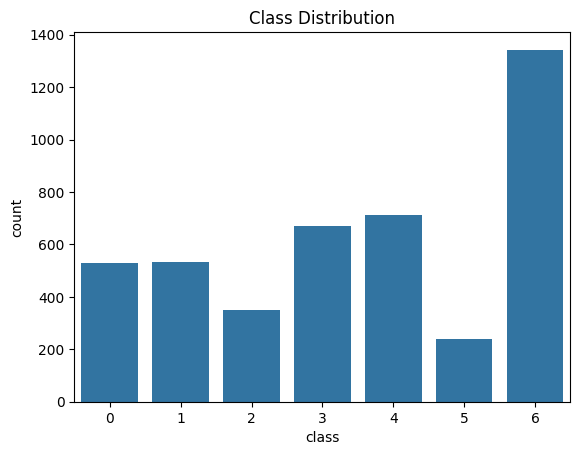

In [ ]:
sns.countplot(data=data, x='class')
plt.title('Class Distribution')
plt.show()


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB
None


In [ ]:
print(data.describe())

             class
count  4380.000000
mean      3.504566
std       2.132134
min       0.000000
25%       2.000000
50%       4.000000
75%       6.000000
max       6.000000


In [ ]:
print(data.nunique())

sequence    3629
class          7
dtype: int64


In [ ]:
data.shape

(4380, 3)

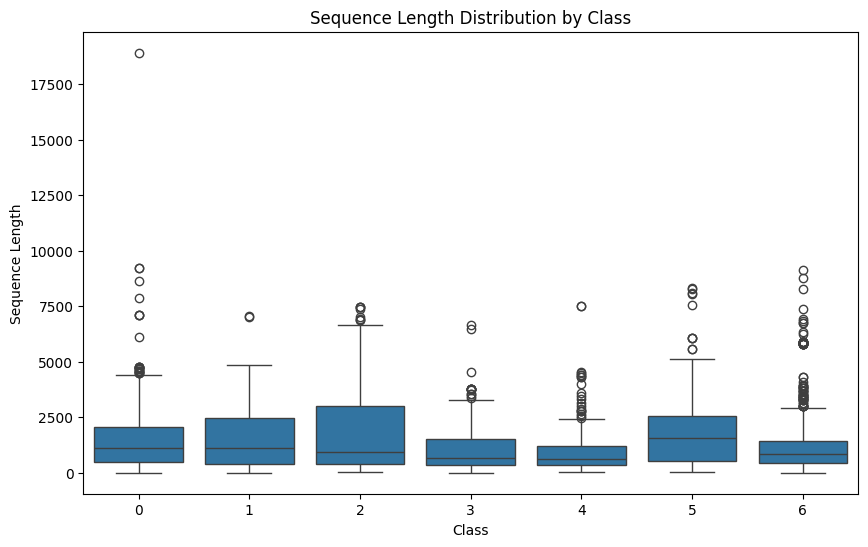

In [ ]:
data['sequence_length'] = data['sequence'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='sequence_length', data=data)
plt.title('Sequence Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Sequence Length')
plt.show()


In [ ]:
def remove_outliers(group):
    Q1 = group['sequence_length'].quantile(0.25)
    Q3 = group['sequence_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return group[(group['sequence_length'] >= lower_bound) & (group['sequence_length'] <= upper_bound)]

data_cleaned = data.groupby('class').apply(remove_outliers)

print(f"Number of values remaining after removing outliers: {len(data_cleaned)}")




Number of values remaining after removing outliers: 4236


<ipython-input-21-1967ac3fb0bb>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data.groupby('class').apply(remove_outliers)


In [ ]:
data_cleaned.shape

(4306, 3)

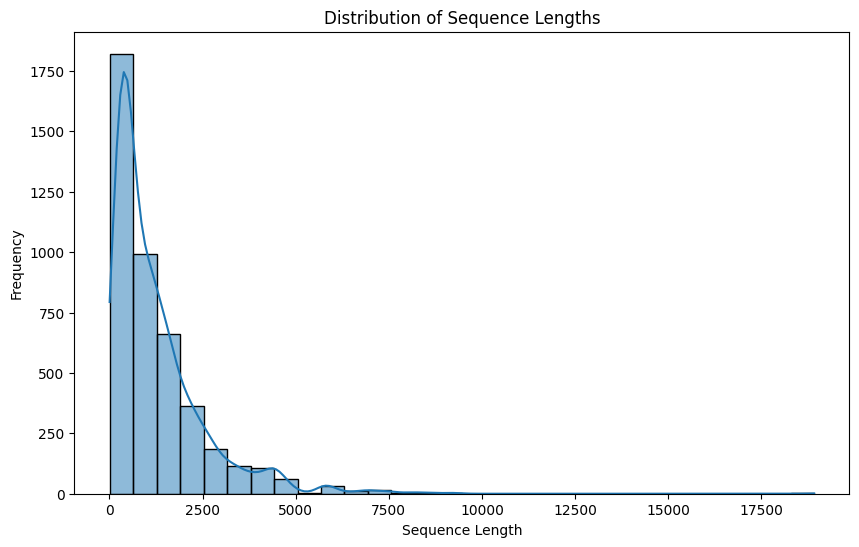

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['sequence_length'], kde=True, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


#K-mers

In [ ]:


def get_kmers(sequence, k=6):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

data_cleaned['kmers'] = data_cleaned['sequence'].apply(lambda x: get_kmers(x, k))

all_kmers = list(chain(*data_cleaned['kmers'].values))
vocab = {kmer: idx+1 for idx, kmer in enumerate(set(all_kmers))}
vocab_size = len(vocab) + 1

data_cleaned['encoded_kmers'] = data_cleaned['kmers'].apply(lambda kmers: [vocab[kmer] for kmer in kmers if kmer in vocab])

max_length = min(max(len(seq) for seq in data_cleaned['encoded_kmers']), 500)
print(f"Max Sequence Length: {max_length}")


X_padded = tf.keras.preprocessing.sequence.pad_sequences(data_cleaned['encoded_kmers'], maxlen=max_length, padding="post")



Max Sequence Length: 500


# **Models**

#LSTM

In [ ]:

y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


In [ ]:


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    BatchNormalization(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(set(y)), activation="softmax")
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Accuracy on test set: {test_acc:.2%}")


Max Sequence Length: 500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1603s 14s/step - accuracy: 0.2812 - loss: 1.8403 - val_accuracy: 0.4258 - val_loss: 1.8204
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1624s 14s/step - accuracy: 0.6776 - loss: 1.0046 - val_accuracy: 0.6290 - val_loss: 1.6925
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1582s 14s/step - accuracy: 0.8447 - loss: 0.5065 - val_accuracy: 0.7192 - val_loss: 1.1908
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1590s 14s/step - accuracy: 0.9021 - loss: 0.3102 - val_accuracy: 0.7249 - val_loss: 0.9110
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1580s 14s/step - accuracy: 0.9425 - loss: 0.1825 - val_accuracy: 0.7158 - val_loss: 0.9482
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1607s 15s/step - accuracy: 0.9629 - loss: 0.1364 - val_accuracy: 0.7523 - val_loss: 1.2906
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1671s 15s/step - accuracy: 0.9560 - loss: 0.1313 - val_accuracy: 0.7568 - val_loss: 1.3393
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1580s 14s/step - accuracy: 0.9611 - loss: 0

# Transformer-based classifier

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

max_length = min(max(len(seq) for seq in data_cleaned['encoded_kmers']), 500)
print(f"Max Sequence Length: {max_length}")

X_padded = tf.keras.preprocessing.sequence.pad_sequences(data_cleaned['encoded_kmers'], maxlen=max_length, padding="post")
y = torch.tensor(data_cleaned['class'].values, dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train, X_val, X_test = map(lambda x: torch.tensor(x, dtype=torch.long), [X_train, X_val, X_test])

batch_size = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False, pin_memory=True)

class DNA_Transformer(nn.Module):
    def __init__(self, vocab_size, embed_size=64, num_heads=8, num_classes=7, num_layers=2, hidden_size=256):
        super(DNA_Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            dim_feedforward=hidden_size
        )
        self.fc1 = nn.Linear(embed_size, 256)
        self.batch_norm = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x, x)
        x = x[-1, :, :]
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

vocab_size = len(vocab) + 1
model = DNA_Transformer(vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
accuracy = 100 * correct / total
print(f"Final Accuracy on test set: {accuracy:.2f}%")


Using device: cuda
Max Length: 500
Unique labels in dataset: tensor([0, 1, 2, 3, 4, 5, 6])
Min index in X_padded: 0, Max index in X_padded: 4469
Unique labels in y: tensor([0, 1, 2, 3, 4, 5, 6])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Loss: 2.1451, Accuracy: 15.78%
Epoch [2/50], Loss: 1.9450, Accuracy: 24.77%
Epoch [3/50], Loss: 1.7903, Accuracy: 33.56%
Epoch [4/50], Loss: 1.6592, Accuracy: 40.72%
Epoch [5/50], Loss: 1.5441, Accuracy: 47.03%
Epoch [6/50], Loss: 1.4138, Accuracy: 51.51%
Epoch [7/50], Loss: 1.2911, Accuracy: 56.48%
Epoch [8/50], Loss: 1.2007, Accuracy: 59.30%
Epoch [9/50], Loss: 1.0779, Accuracy: 64.21%
Epoch [10/50], Loss: 0.9735, Accuracy: 67.81%
Epoch [11/50], Loss: 0.8823, Accuracy: 70.92%
Epoch [12/50], Loss: 0.8321, Accuracy: 73.23%
Epoch [13/50], Loss: 0.7473, Accuracy: 76.51%
Epoch [14/50], Loss: 0.6505, Accuracy: 78.82%
Epoch [15/50], Loss: 0.6072, Accuracy: 80.59%
Epoch [16/50], Loss: 0.5201, Accuracy: 83.88%
Epoch [17/50], Loss: 0.4789, Accuracy: 84.99%
Epoch [18/50], Loss: 0.4488, Accuracy: 85.82%
Epoch [19/50], Loss: 0.4002, Accuracy: 87.67%
Epoch [20/50], Loss: 0.3756, Accuracy: 88.30%
Epoch [21/50], Loss: 0.3522, Accuracy: 89.55%
Epoch [22/50], Loss: 0.3245, Accuracy: 89.8